## Precipitation Prediction: A Machine Learning Tutorial
Learning Objectives:

Understand time series data preprocessing

Learn feature engineering techniques

Implement machine learning models for weather prediction

Evaluate model performance

In [32]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [33]:
# Load netCDF dataset
ds = xr.open_dataset('dataset_precip.nc')
print(ds)

# Convert to DataFrame
df = ds.to_dataframe().reset_index()
df = df.dropna()

# Scale precipitation to mm/day
df['tp'] = df['tp'] * 1000

<xarray.Dataset> Size: 15kB
Dimensions:  (time: 730)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2022-01-01T12:00:00 ... 2023-12-31T12:...
Data variables:
    tcwv     (time) float32 3kB ...
    tcc      (time) float32 3kB ...
    tp       (time) float32 3kB ...
Attributes:
    description:    Merged ERA5 and MODIS AOD dataset
    creation_date:  2024-12-29
    time_zone:      UTC
    region:         51E-52E, 35N-36N


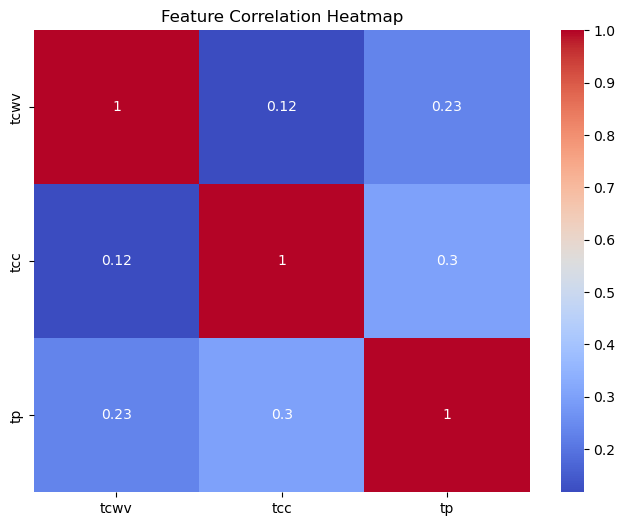

In [34]:
# Create correlation heatmap
plt.figure(figsize=(8, 6))
corr_matrix = df[['tcwv', 'tcc', 'tp']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

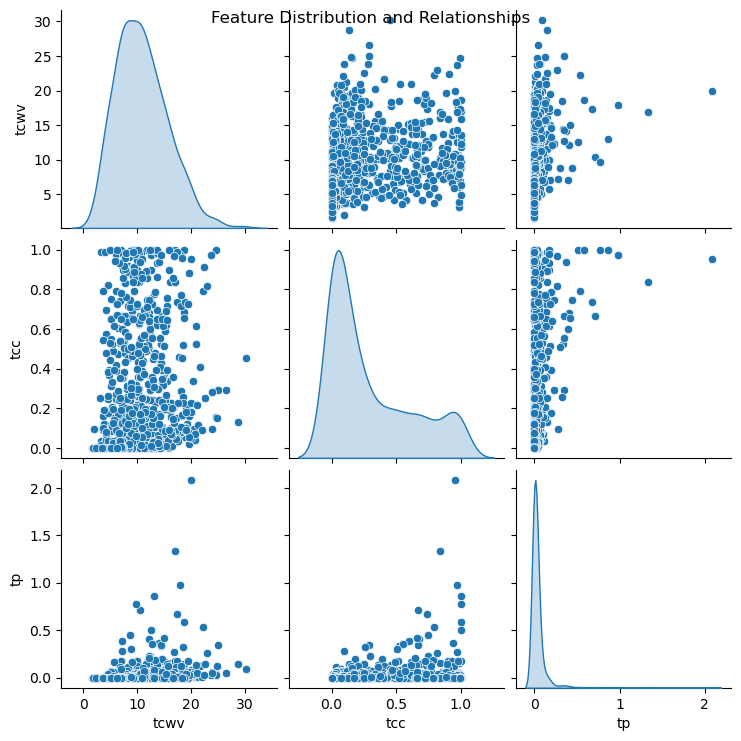

In [35]:
# Pairplot to visualize feature relationships
sns.pairplot(df[['tcwv', 'tcc', 'tp']], diag_kind='kde')
plt.suptitle('Feature Distribution and Relationships')
plt.show()

In [36]:
def create_lag_features(df, lags=[1, 2]):
    for lag in lags:
        df[f'tcwv_lag{lag}'] = df['tcwv'].shift(lag)
        df[f'tcc_lag{lag}'] = df['tcc'].shift(lag)
        df[f'tp_lag{lag}'] = df['tp'].shift(lag)
    
    return df.dropna().reset_index(drop=True)

# Generate lag features
df_lagged = create_lag_features(df)

In [37]:
# Define feature columns
features = ['tcwv', 'tcc', 'tp_lag1', 'tcwv_lag1', 'tcc_lag1', 
            'tp_lag2', 'tcwv_lag2', 'tcc_lag2']

# Split data
X = df_lagged[features]
y = df_lagged['tp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# Initialize and train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    random_state=56
)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=56)

In [39]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 0.0476
Mean Absolute Error: 0.0692
R² Score: 0.1840


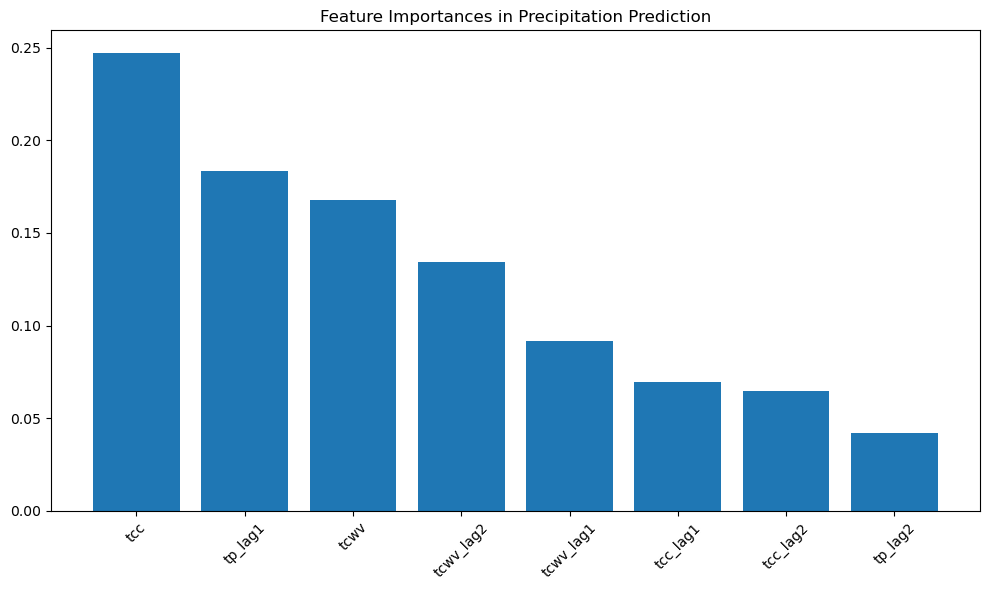

In [40]:
# Plot feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances in Precipitation Prediction")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

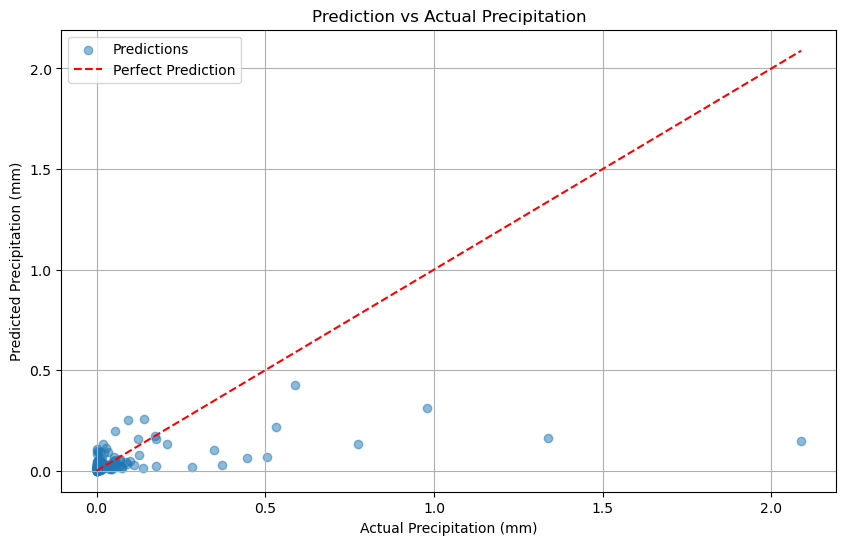

In [41]:
# Create Prediction vs Actual Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Precipitation (mm)')
plt.ylabel('Predicted Precipitation (mm)')
plt.title('Prediction vs Actual Precipitation')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
# Example prediction
new_data = pd.DataFrame({
    'tcwv': [17.0],
    'tcc': [0.7],
    'tp_lag1': [0.0],
    'tcwv_lag1': [18.2],
    'tcc_lag1': [1.0],
    'tp_lag2': [0.0],
    'tcwv_lag2': [25.0],
    'tcc_lag2': [0.95]
})

predicted_precipitation = rf_model.predict(new_data)
print(f"Predicted Precipitation: {predicted_precipitation[0]:.2f} mm")

Predicted Precipitation: 0.24 mm
